In [ ]:
#@title Imports
import random
import math
import numpy as np
import skimage as img
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import copy

import scipy.ndimage as ndimg
import skimage.io as io
from skimage.exposure import equalize_hist
from skimage.color import rgb2gray
from skimage.filters import (gaussian,threshold_sauvola,threshold_niblack,sobel,sobel_h,sobel_v,laplace,scharr,gabor,rank)
from skimage.util import crop,invert
from skimage.morphology import (disk,skeletonize)

In [ ]:
#title Preprocessing
def preprocess(img):
    gray_image = rgb2gray(img)
    cropped = crop(gray_image, ((50,50), (50,50)), copy = False)
    equalized_image=rank.equalize(cropped,selem=disk(5))
    blur=gaussian(equalized_image,sigma=1.4)
    binary = np.where(blur > np.mean(blur),1.0,0.0)
    skeleton=skeletonize(binary)
    skeleton=invert(skeleton)

    return (skeleton,gray_image)

In [ ]:
#title Crossing Number , crossnum(skel)
def crossnum(skel):
    (m,n)=skel.shape
    skel = 1*skel
    minutiae=[]
    
    for i in range(m-2):
        for j in range(n-2):
            if (skel[i+1][j+1]==1):
                continue
            c = 0;
            c=skel[i][j]+skel[i][j+1]+skel[i][j+2]+skel[i+1][j]+skel[i+1][j+1]+skel[i+1][j+2]+skel[i+2][j]+skel[i+2][j+1]+skel[i+2][j+2]
            if (c==7 or c==5):
                minutiae += [(i+1,j+1)]
    return minutiae

In [ ]:
#title Orientation Field
def orientationField(img,sigma):#img is cropped but not binary
    Gx = sobel_v(img)
    GX = np.array(Gx)
    Gy = sobel_h(img)
    Gy = np.array(Gy)
    
    fp = np.ones((7,7))
    
    def fn(x):
        return x.sum()

    Vx = 2*Gx*Gy
    Vx = ndimg.generic_filter(Vx, fn, footprint=fp)
    Vy = (Gx*Gx)*(Gy*Gy)
    Vy = ndimg.generic_filter(Vy, fn, footprint=fp)
    orientationField = (1/2)*np.arctan2(Vy,Vx)

    thetaX = np.cos(2*orientationField)
    thetaY = np.sin(2*orientationField)
    thetaX = gaussian(thetaX,sigma)
    thetaX = gaussian(thetaX,sigma)

    orientationField = 1/2*np.arctan2(thetaY,thetaX)
    return orientationField

In [ ]:
#title feature store
#markdown to store the orientations of the points around a minutiae
def surrounding(mylist,orient):
    r1 = 20
    r2 = 40
    k1 = 36 # k = 172xr/Resolution(DPI)
    k2 = 72
    store1 = []
    for (m,n) in mylist:
        temp=[]
        for i in range(k1):
            temp+=[orient1[m+round(r1*math.cos(i*2*np.pi/k1))][n+round(r1*math.sin(i*2*np.pi/k1))]]
        for i in range(k2):
            temp+=[orient1[m+round(r2*math.cos(i*2*np.pi/k2))][n+round(r2*math.sin(i*2*np.pi/k2))]]
        store1.append(temp)
    return store1

In [ ]:
#title Similarity Matrix Generationn
#markdown Create a Similarity matrix to store Wii'jj' and hardcoded d_rc,d_theta,d_dist, they have to be changed
def simiMat(list1,list2,store1,store2,orient1,orient2,skel1,skel2):
    m = len(list1)
    n = len(list2)
    mat = []
    
    for i1 in range(m):
        print("\r",i1,end="")
        for i2 in range(n):
            t = []
            for j1 in range(m):
                for j2 in range(n):
                    if ((i1==j1 and i2!=j2)or(i1!=j1 and i2==j2)):
                        t += [0]
                    elif (i1==j1 and i2==j2):
                        t += [value(store1[i1],store2[i2])]
                    else:
                        t += [value_pair(list1[i1], list1[j1], list2[i2], list2[j2], 
                                          orient1[list1[i1][0]][list1[i1][1]], orient1[list1[j1][0]][list1[j1][1]],
                                          orient2[list2[i2][0]][list2[i2][1]], orient2[list2[j2][0]][list2[j2][1]], skel1, skel2, 2, 0.2, 4)] ## hardcoded
            mat += [t]
    return mat

In [ ]:
#title S(a,a) minutiae wise similarity
def value(sur1,sur2):
    sum = 0
    for i in range(108):
        sum += math.exp(-32*abs(sur1[i]-sur2[i])/np.pi)
    sum /= 108
    return sum

In [ ]:
#@title Minitiae pair wise similarity S(a,b)
def value_pair(ixy, i2xy, jxy, j2xy, oi1, oi2, oj1, oj2, img1, img2, d_rc, d_theta, d_dist):
    ## for first finger
    rcA = 0
    prev = True
    x_diff = i2xy[0]-ixy[0]
    y_diff = i2xy[1]-ixy[1]
    if (x_diff >= y_diff):
        for i in range(1,x_diff):
            y_now = ixy[1]+math.floor(y_diff*(i*1.0/x_diff))
            if (img1[ixy[0]+i][y_now] == 1):
                if (not prev):
                    rcA += 1
                    prev = True
            else:
                prev = False
        if (not prev):
            rcA += 1
    else:
        for i in range(1,y_diff):
            x_now = ixy[0]+math.floor(x_diff*(i*1.0/y_diff))
            if (img1[x_now][ixy[1]+i] == 1):
                if (not prev):
                    rcA += 1
                    prev = True
            else:
                prev = False
        if (not prev):
            rcA += 1


    ## for second finger
    rcB = 0
    prev = True
    x_diff = j2xy[0]-jxy[0]
    y_diff = j2xy[1]-jxy[1]
    if (x_diff >= y_diff):
        for i in range(1,x_diff):
            y_now = jxy[1]+math.floor(y_diff*(float(i)/x_diff))
            if (img2[jxy[0]+i][y_now] == 1):
                if (not prev):
                    rcB += 1
                    prev=True
            else:
                prev=False
        if (not prev):
            rcB += 1
    else:
        for i in range(1,y_diff):
            x_now = jxy[0]+math.floor(x_diff*(float(i)/y_diff))
            if (img2[x_now][jxy[1]+i] == 1):
                if (not prev):
                    rcB += 1
                    prev = True
            else:
                prev=False
        if (not prev):
            rcB += 1
    
    rc_diff = abs(rcA-rcB)
    
    thetaA = oi1 - oi2
    thetaB = oj1 - oj2
    theta_diff = abs(thetaA - thetaB)
    theta_diff = theta_diff%(np.pi)

    distA = ( (ixy[0]-i2xy[0])**2 + (ixy[1]-i2xy[1])**2 )**(0.5)
    distB = ( (jxy[0]-j2xy[0])**2 + (jxy[1]-j2xy[1])**2 )**(0.5)
    dist_diff = abs(distA-distB)
    
    return -1 if (rc_diff > d_rc or theta_diff > d_theta or dist_diff > d_dist) else 1

In [ ]:
#title normalize similarity matrix
def normMwiseSimi(simiMatrix,m,n):
    mn = sys.maxsize
    mx = -mn    
    sum = 0.0
    for i1 in range(m):
        for i2 in range(n):
            if (simiMatrix[n*i1+i2][n*i1+i2] < mn):
                mn = simiMatrix[n*i1+i2][n*i1+i2]
            if (simiMatrix[n*i1+i2][n*i1+i2] > mx):
                mx = simiMatrix[n*i1+i2][n*i1+i2]
    for i1 in range(m):
        for i2 in range(n):
            simiMatrix[n*i1+i2][n*i1+i2] = (2)*((simiMatrix[n*i1+i2][n*i1+i2] - mn)/float(mx-mn))-1
    return simiMatrix

In [ ]:
#title GAString
## class definition for creating a member of a population 
## nq is no of genes in each member in the population 
## nt is the limit on the possible value in each gene of the member 
class GAString():
    def __init__(self,nt,nq,genes=None):
        assert nq>0 and nt>0
        self.nq = nq
        self.nt = nt
        self.genes = np.copy(genes) if genes is not None else self.randInit();
        
    def __str__(self):
        return " ".join(map(str,self.genes))
        
    def randInit(self):
        genes = np.empty(self.nq, dtype=int)
        numbers = [0 for i in range(self.nq)]
        for i in range(1,self.nt+1):
            numbers.append(i)
        random.shuffle(numbers)
        for i in range(self.nq):
            genes[i] = numbers[i]
        return genes
    
    def __lt__(self, other):
        for b1,b2 in zip(self.genes,other.genes):
            if b1 < b2:
                return True
            elif b1 > b2:
                return False
        return False
    
    def __le__(self, other):
        return self.__lt__(other) or self.__eq__(other)
    
    def __ge__(self, other):
        return self.__gt__(other) or self.__eq__(other)
    
    def __gt__(self, other):
        for b1,b2 in zip(self.genes,other.genes):
            if b1 > b2:
                return True
            elif b1 < b2:
                return False
        return False
    
    def __eq__(self, other):
        return self.nq == other.nq and np.array_equal(np.array(self.genes), np.array(other.genes))
    
    def __ne__(self, other):
        return self.nq != other.nq or not np.array_equal(np.array(self.genes), np.array(other.genes))

    def __hash__(self):
        return hash(tuple(self.genes+[self.nq]))

In [ ]:
#title Population Initialization
##initialize the population
def initPop(size_pop,nt,nq):
    assert size_pop>0
    assert nq>0
    assert nt>0
    pop = []
    while(len(pop)<20):
        pop += [GAString(nt,nq)]
        pop = list(set(pop))
    return pop

In [ ]:
#title crossover operation
def crossover(parent1,parent2):
    assert parent1.nq == parent2.nq
    
    A = [(j,parent1.genes[j]) for j in range(parent1.nq)]
    B = [(j,parent2.genes[j]) for j in range(parent2.nq)]
    C = []
    for i in range(parent1.nq):
        for j in range(parent2.nq):
            if (parent1.genes[i]==parent2.genes[j]):
                C.append(parent1.genes[i])
    DA = []
    for i in range(parent1.nq):
        if ((parent1.genes[i] not in parent2.genes)):
            DA.append(parent1.genes[i])
    DB = []
    for i in range(parent2.nq):
        if ((parent2.genes[i] not in parent1.genes)):
            DB.append(parent2.genes[i])
    n1=0
    if (len(C)!=0):
        n1 = random.randrange(1,len(C)+1)
    Ccopy = C.copy()
    random.shuffle(Ccopy)
    Cn1 = [Ccopy[j] for j in range(n1)]
    n2=0
    if (min(len(DA),len(DB))!=0):
        n2 = random.randrange(1,min(len(DA),len(DB))+1)
    DAcopy = DA.copy()
    random.shuffle(DAcopy)
    DAn2 = [DAcopy[j] for j in range(n2)]
    DBcopy = DB.copy()
    random.shuffle(DBcopy)
    DBn2 = [DBcopy[j] for j in range(n2)]
    S1 = Cn1+DAn2
    S2 = Cn1+DBn2
    S2dash = S2.copy()
    random.shuffle(S2dash)

    
    child1genes = []
    S1_copy = S1.copy()
    S2dash_copy = S2dash.copy()
    for i in range(parent1.nq):
        if (parent1.genes[i] in S1_copy):
            idx = S1_copy.index(parent1.genes[i])
            child1genes += [S2dash_copy[idx]]
            S1_copy.remove(parent1.genes[i])
            S2dash_copy.remove(S2dash_copy[idx])
        else:
            child1genes += [parent1.genes[i]]

    
    child2genes = []
    S1_copy = S1.copy()
    S2dash_copy = S2dash.copy()
    for i in range(parent1.nq):
        if (parent2.genes[i] in S2dash_copy):
            idx = S2dash_copy.index(parent2.genes[i])
            child2genes += [S1_copy[idx]]
            S1_copy.remove(S1_copy[idx])
            S2dash_copy.remove(parent2.genes[i])
        else:
            child2genes += [parent2.genes[i]]
    
    child1 = GAString(parent1.nt,parent1.nq,child1genes)
    child2 = GAString(parent1.nt,parent1.nq,child2genes)
    
    return [child1,child2]

In [ ]:
#title mutation of non-zero to zero
def mutnz2z(dude):
    nq = dude.nq
    z=[]
    for i in range(nq):
        if dude.genes[i] != 0:
            z.append(i)
    if (len(z) == 0):
        return dude
    dude.genes[random.choice(z)] = 0
    return dude

In [ ]:
#title mutation of zero to non-zero
def mutz2nz(dude):
    numbers = [i for i in range(1,dude.nt+1)]
    z = []
    for i in range(dude.nq):
        if (dude.genes[i] == 0):
            z.append(i)
        else:
            numbers.remove(dude.genes[i])
            
    if ((len(z) == 0) or (len(numbers) == 0)):
        return dude
    dude.genes[random.choice(z)] = random.choice(numbers)
    return dude

In [ ]:
#title mutation of swapping values
def mutswap(dude):
    valid=[]
    for i in range(dude.nq):
        if(dude.genes[i]!=0):
            valid += [i]
    if(len(valid)<2):
        return dude
    while(True):
        indexes = random.sample(valid,2)
        index1 = indexes[0]
        index2 = indexes[1]
        if ((dude.genes[index1] == 0) or (dude.genes[index2] == 0)):
            continue
        else:
            dude.genes[index1],dude.genes[index2] = dude.genes[index2],dude.genes[index1]
            break
    return dude

In [ ]:
#title mutation operator
def mutation(dude):
    r = random.randrange(0,3)
#     print("r=",r,end="")
    if (r==0):
        dude = mutnz2z(dude)
    elif (r==1):
        dude = mutz2nz(dude)
    elif (r==2):
        dude = mutswap(dude)
#     print("mutated", end = ", ")
    return dude

In [ ]:
#title Single Generation simulation in GA
def singleGen(pop,crosses,muts):# pop is population, Cr is Crossover ratio, Mr is mutation ratio, G is max no.of generations, Xini is initial best individual
    n = len(pop)
    nums = [i for i in range(n)]
    random.shuffle(nums)
    nums=nums[:crosses]
    for i in range(crosses//2):
        pop += crossover(copy.deepcopy(pop[nums[2*i]]),copy.deepcopy(pop[nums[2*i+1]]))
    nums = [i for i in range(n)]
    random.shuffle(nums)
    nums=nums[:muts]
    for i in range(muts):
        pop += [mutation(copy.deepcopy(pop[nums[i]]))]
    return pop

In [ ]:
def croselect(pop,crosses,values):
    val_cop = values.copy()
    val_cop = sorted(val_cop)
    mn = val_cop[0]
    mx = val_cop[len(pop)-1]-mn
    mix = 0
    for i in range(len(pop)):
        values[i] = values[i]-mn
        mix+=values[i]
        
    temp = list(zip(values,pop))
    random.shuffle(temp)
    val,dudes = zip(*temp)
    val = list(val)
    dudes = list(dudes)
    k = float(mix)/crosses
    crosspop = []
    th = random.random()*k
    summ=0
    for i in range(crosses):
        summ+=val[i]
        while(True):
            if (summ>th):
                crosspop += [dudes[i]]
                th += k
            else : 
                break
    random.shuffle(crosspop)
    return crosspop

In [ ]:
#title Single Generation simulation in GA
def singleGenMod(pop,crosses,muts,values):# pop is population, Cr is Crossover ratio, Mr is mutation ratio, G is max no.of generations, Xini is initial best individual
    n = len(pop)
    crosspop = croselect(pop,crosses,values)
    for i in range(crosses//2):
        pop += crossover(copy.deepcopy(crosspop[2*i]),copy.deepcopy(crosspop[2*i+1]))
    nums = [i for i in range(n)]
    random.shuffle(nums)
    nums=nums[:muts]
    for i in range(muts):
        pop += [mutation(copy.deepcopy(pop[nums[i]]))]
    pop = list(set(pop))
    return pop

In [ ]:
#title vectorize
def fofx(dude,simiMatrix):
    X = np.zeros((dude.nt,dude.nq))
    for i in range(dude.nq):
        num = dude.genes[i]
        if (num != 0):
            X[num-1][i] = 1
    dudearray = np.reshape(X,(len(simiMatrix),1))
    simiarray = np.array(simiMatrix)
    xTW = np.matmul(dudearray.T,simiarray)
    xTWx = np.matmul(xTW,dudearray)
    return xTWx

In [ ]:
#title Loose GA
def looseGA(pop,Cr,Mr,G,simiMatrix,nt,nq):
    n=len(pop)
    finger1=crossnum(skel1)
    finger2=crossnum(skel2)
    crosses=int(round((Cr*n)/2))*2
    muts=int(round(Mr*n))

    values = []
    for j in range(len(pop)):
        values+=[fofx(pop[j],simiMatrix)[0][0]]
    
    
    for i in range(G):
        
        pop=singleGenMod(pop,crosses,muts,values)

        values=[]
        for j in range(len(pop)):
            values+=[fofx(pop[j],simiMatrix)[0][0]]
        
        temp = list(zip(values,pop))
        temp = sorted(temp)
        values,pop = zip(*temp)

        pop = list(pop)
        values = list(values)


        pop = pop[len(pop)-n:]
        values = values[len(values)-n:]

        print("best",values[n-1],"2nd best",values[n-2],"3rd best",values[n-3])
        print("best_dude",pop[n-1])
        print()
    return pop[n-1],values[n-1]

In [ ]:
def pairexpand(dude,list1,list2,orient1,orient2,img1,img2,d_RC,d_Theta):##images are skeletons
    nq = dude.nq
    nt = dude.nt
    T = []
    Q = []
    TT = [i for i in range(1,nt+1)]
    QQ = [i for i in range(1,nq+1)]
    for i in range(nq):
        if (dude.genes[i]!=0):
            T += [dude.genes[i]]
            Q += [i+1]
            TT.remove(dude.genes[i])
            QQ.remove(i+1)
    while(len(TT)!=0 and len(QQ)!=0):

        
        RCi = np.zeros((nt,nt))
        RCj = np.zeros((nq,nq))
        Thetai = np.zeros((nt,nt))
        Thetaj = np.zeros((nq,nq))
        for p in TT:
            for q in T:
                prev = True
                x_diff = list1[q-1][0]-list1[p-1][0]
                y_diff = list1[q-1][1]-list1[p-1][1]
                if (x_diff >= y_diff):
                    for i in range(1,x_diff):
                        y_now = list1[p-1][1]+math.floor(y_diff*(i*1.0/x_diff))
                        if (img1[list1[p-1][0]+i][y_now] == 1):
                            if (not prev):
                                RCi[p-1][q-1] += 1
                                prev = True
                        else:
                            prev = False
                    if (not prev):
                        RCi[p-1][q-1] += 1
                else:
                    for i in range(1,y_diff):
                        x_now = list1[p-1][0]+math.floor(x_diff*(i*1.0/y_diff))
                        if (img1[x_now][list1[p-1][1]+i] == 1):
                            if (not prev):
                                RCi[p-1][q-1] += 1
                                prev = True
                        else:
                            prev = False
                    if (not prev):
                        RCi[p-1][q-1] += 1
        for p in QQ:
            for q in Q:
                prev = True
                x_diff = list2[q-1][0]-list2[p-1][0]
                y_diff = list2[q-1][1]-list2[p-1][1]
                if (x_diff >= y_diff):
                    for i in range(1,x_diff):
                        y_now = list2[p-1][1]+math.floor(y_diff*(i*1.0/x_diff))
                        if (img2[list2[p-1][0]+i][y_now] == 1):
                            if (not prev):
                                RCj[p-1][q-1] += 1
                                prev = True
                        else:
                            prev = False
                    if (not prev):
                        RCj[p-1][q-1] += 1
                else:
                    for i in range(1,y_diff):
                        x_now = list2[p-1][0]+math.floor(x_diff*(i*1.0/y_diff))
                        if (img2[x_now][list2[p-1][1]+i] == 1):
                            if (not prev):
                                RCj[p-1][q-1] += 1
                                prev = True
                        else:
                            prev = False
                    if (not prev):
                        RCj[p-1][q-1] += 1
        for p in TT:
            for q in T:
                Thetai[p-1][q-1] = orient1[list1[p-1][0]][list1[p-1][1]]-orient1[list1[q-1][0]][list1[q-1][1]]
        for p in QQ:
            for q in Q:
                Thetaj[p-1][q-1] = orient2[list2[p-1][0]][list2[p-1][1]]-orient2[list2[q-1][0]][list2[q-1][1]]
        mn = sys.maxsize
        mnpq = [0,0]
        for p in range(len(TT)):
            for q in range(len(QQ)):
                summ=0
                for m in range(nq):
                    if (abs(RCi[p-1][dude.genes[m]-1]-RCj[q-1][m])>d_RC or abs(Thetai[p-1][dude.genes[m]-1]-Thetaj[q-1][m])>d_Theta):
                        summ = sys.maxsize
                        break
                    else :
                        summ += pow((RCi[p-1][dude.genes[m]-1]-RCj[q-1][m]),2)
                if(summ<mn):
                    mn=summ
                    mnpq = [p,q]
        if (mn==sys.maxsize):
            break
        else :
            T += [TT[mnpq[0]]]
            Q += [QQ[mnpq[1]]]
            dude.genes[QQ[mnpq[1]]-1] = TT[mnpq[0]]
            TT.remove(TT[mnpq[0]])
            QQ.remove(QQ[mnpq[1]])

    return dude

In [ ]:
    def cscore(gem,gemval):
        nz=0
        for i in gem.genes:
            if (i!=0):
                nz += 1
        if (nz==0):
            return -1
        score = (2*gemval)/(nz*(gem.nt+gem.nq))
        return score

/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


Streaming output truncated to the last 5000 lines.
pop + len 60
best 0.0 2nd best -0.03469921151047828 3rd best -0.3132463152699341
best_dude 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

gen :  2
pop + len 48
best 3.0256009586575434 2nd best 0.2499962237703992 3rd best 0.21164558926759347
best_dude 0 5 0 0 0 0 0 0 0 0 0 16 0 0 0 0 3 0 0

gen :  3
pop + len 33
best 3.036050948291039 2nd best 3.0256009586575434 3rd best 2.989550010366504
best_dude 0 5 0 0 0 0 0 0 0 0 0 16 0 0 0 0 0 0 0

gen :  4
pop + len 37
best 3.036050948291039 2nd best 3.0256009586575434 3rd best 2.989550010366504
best_dude 0 5 0 0 0 0 0 0 0 0 0 16 0 0 0 0 0 0 0

gen :  5
pop + len 33
best 3.0690265192001274 2nd best 3.036050948291039 3rd best 3.0256009586575434
best_dude 3 0 0 0 0 0 0 0 0 0 0 16 0 0 0 0 0 0 0

gen :  6
pop + len 37
best 3.0690265192001274 2nd best 3.036050948291039 3rd best 3.0256009586575434
best_dude 3 0 0 0 0 0 0 0 0 0 0 16 0 0 0 0 0 0 0

gen :  7
pop + len 40
best 3.0690265192001274 2nd best 3.0360509

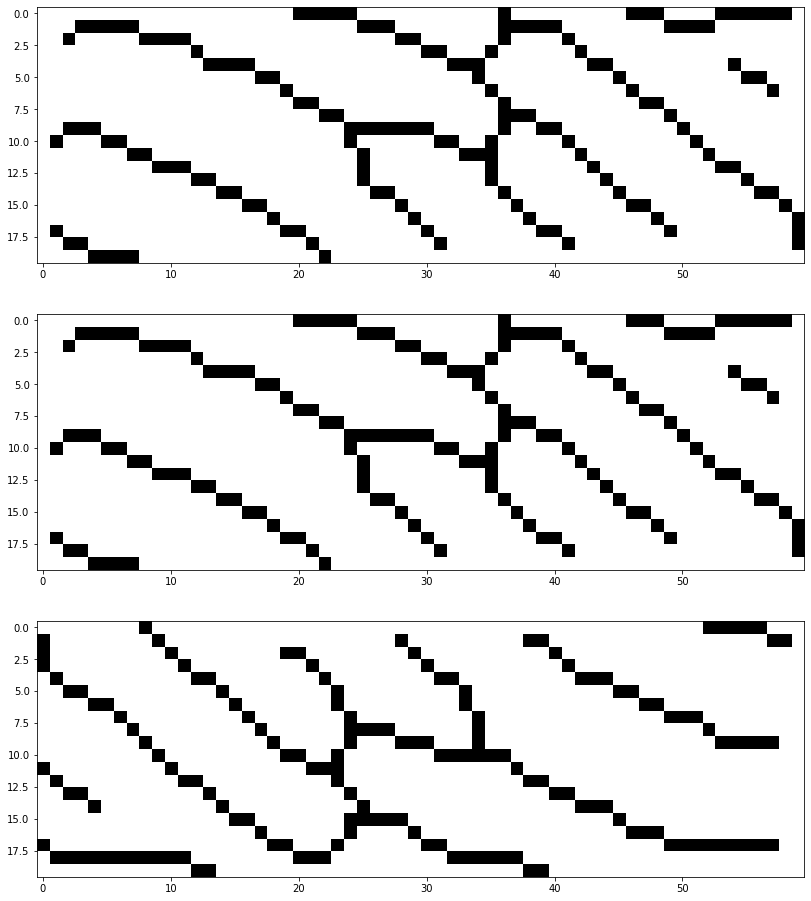

In [ ]:
#@title main
img1 = io.imread("3-test.png")
img2 = io.imread("3-test.png")
img3 = io.imread("3-test_inv.png")

skel1,gray1 = preprocess(img1)
skel2,gray2 = preprocess(img2)
skel3,gray3 = preprocess(img3)

fig, axes = plt.subplots(3,1,False,False,True,figsize = (16,16))
ax = axes.ravel()
ax[0].imshow(skel1, cmap=plt.cm.gray)
ax[1].imshow(skel2, cmap=plt.cm.gray)
ax[2].imshow(skel3, cmap=plt.cm.gray)

list1 = crossnum(skel1)
list2 = crossnum(skel2)
list3 = crossnum(skel3)

orient1 = orientationField(gray1,1)
orient2 = orientationField(gray2,1)
orient3 = orientationField(gray3,1)

store1  = surrounding(list1,orient1)
store2  = surrounding(list2,orient2)
store3  = surrounding(list3,orient3)

print("list1",list1)
print("list3",list3)

simiMatrix = simiMat(list1,list2,store1,store2,orient1,orient2,skel1,skel2)
simiMatrix = normMwiseSimi(simiMatrix,len(list1),len(list2))
pop = initPop(20,len(list1),len(list2))
gem,gemval = looseGA(pop,1,1,100,simiMatrix,len(list1),len(list2))
print("fingers 1,2 over and 1,10 has to begin")

simiMatrix = simiMat(list1,list3,store1,store3,orient1,orient3,skel1,skel3)
simiMatrix = normMwiseSimi(simiMatrix,len(list1),len(list3))
pop = initPop(20,len(list1),len(list3))
gem1,gemval1 = looseGA(pop,1,1,1000,simiMatrix,len(list1),len(list3))
print("fingers 1,10 over")

print("1,2",gemval,"gem 1,2 is",gem)
print("1,10",gemval1,"gem 1,10 is",gem1)

nz=0
for i in gem.genes:
    if (i!=0):
        nz += 1
compg = (2*gemval)/(nz*(gem.nt+gem.nq))
print("compg:",compg)
nz=0
for i in gem1.genes:
    if (i!=0):
        nz += 1
compg = (2*gemval1)/(nz*(gem1.nt+gem1.nq))
print("compg:",compg)

In [ ]:
#@title Waste
#@markdown Not a part of the program
# import skimage.io as io
# import scipy.ndimage as ndi
# from skimage.color import rgb2gray
# import matplotlib.pyplot as plt
# %matplotlib inline

# img = io.imread("download.jpg")
# img = rgb2gray(img)
# img = ndi.sobel(img,1)
# fig , axes = plt.subplots(nrows=1,ncols=2,figsize=(12,24),sharex=False,sharey=True,squeeze=True)
# ax=axes.ravel()
# ax[0].imshow(img, cmap=plt.cm.gray)
# # ax[1].imshow(skeleton1, cmap=plt.cm.gray)
# fig.tight_layout()
# plt.show()

In [ ]:
#@title waste
# import matplotlib
# import matplotlib.pyplot as plt

# from skimage.data import page
# from skimage.filters import (threshold_otsu, threshold_niblack,
#                              threshold_sauvola)


# matplotlib.rcParams['font.size'] = 9


# image = page()
# binary_global = image > threshold_otsu(image)

# window_size = 25
# thresh_niblack = threshold_niblack(image, window_size=window_size, k=0.8)
# thresh_sauvola = threshold_sauvola(image, window_size=window_size)

# binary_niblack = image > thresh_niblack
# binary_sauvola = image > thresh_sauvola

# plt.figure(figsize=(8, 7))
# plt.subplot(2, 2, 1)
# plt.imshow(image, cmap=plt.cm.gray)  
# plt.title('Original')
# plt.axis('off')

# plt.subplot(2, 2, 2)
# plt.title('Global Threshold')
# plt.imshow(binary_global, cmap=plt.cm.gray)
# plt.axis('off')

# plt.subplot(2, 2, 3)
# plt.imshow(binary_niblack, cmap=plt.cm.gray)
# plt.title('Niblack Threshold')
# plt.axis('off')

# plt.subplot(2, 2, 4)
# plt.imshow(binary_sauvola, cmap=plt.cm.gray)
# plt.title('Sauvola Threshold')
# plt.axis('off')

# plt.show()